# Packages & functions

In [31]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from os import listdir

In [32]:
!pip install nose

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
from tensorflow.keras import models

from tensorflow.keras.layers import Conv2D as Conv2D
from tensorflow.keras.layers import BatchNormalization as BatchNormalization
from tensorflow.keras.layers import ReLU as ReLU
from tensorflow.keras.layers import MaxPool2D as MaxPool2D
from tensorflow.keras.layers import Flatten as Flatten
from tensorflow.keras.layers import Dense as Dense
from tensorflow.keras.layers import Input as Input

from os.path import isdir
import os
import numpy as np

from sklearn.model_selection import train_test_split

# Plotting
import seaborn as sns

In [35]:
class DataProperties:
    train_data_path = '/content/drive/MyDrive/UNIPD/HDA/Project/TrainData/'
    test_data_path = '/content/drive/MyDrive/UNIPD/HDA/Project/TestData/'
    
    train_covid_path = train_data_path + 'covid/'
    train_pneumonia_path = train_data_path + 'pneumonia/'
    train_healthy_path = train_data_path + 'normal/'

    test_covid_path = test_data_path + 'covid/'
    test_pneumonia_path = test_data_path + 'pneumonia/'
    test_healthy_path = test_data_path + 'normal/'

    healthy_class = 0
    covid_class = 1
    pneumonia_class = 2
    n_classes = 3

class PreprocParameters:
    resize_shape = (300, 300)
    n_color_channels = (3, )

class DatasetParameters:
    batch_size = 32
    seed = 123
    validation_split = 0.3
    shuffle_train = True
    shuffle_validation = True
    shuffle_test = True

In [36]:
PreprocParameters.resize_shape + PreprocParameters.n_color_channels

(300, 300, 3)

# Data download

## Paths download

In [37]:
# Load filenames
def load_filenames(data_path, max_files = None):
    p = os.listdir(data_path)
    if max_files is not None:
        p = p[: min(max_files, len(p))]
    p = [data_path + file_path for file_path in p]
    return p

def get_filenames(
    covid_path, pneumonia_path, normal_path
):
    return (
        load_filenames(covid_path),
        load_filenames(pneumonia_path),
        load_filenames(normal_path)
    )

In [38]:
train_covid_fnames, train_pn_fnames, train_normal_fnames = get_filenames(
    covid_path = DataProperties.train_covid_path,
    pneumonia_path = DataProperties.train_pneumonia_path,
    normal_path = DataProperties.train_healthy_path
)

test_covid_fnames, test_pn_fnames, test_normal_fnames = get_filenames(
    covid_path = DataProperties.test_covid_path,
    pneumonia_path = DataProperties.test_pneumonia_path,
    normal_path = DataProperties.test_healthy_path
)

In [39]:
def get_labels(
    covid_fnames,
    pn_fnames,
    normal_fnames
):
    return (
        np.full(len(covid_fnames), fill_value = DataProperties.covid_class),
        np.full(len(pn_fnames), fill_value = DataProperties.pneumonia_class),
        np.full(len(normal_fnames), fill_value = DataProperties.healthy_class)
    )

train_covid_labels, train_pn_labels, train_normal_labels = get_labels(
    train_covid_fnames,
    train_pn_fnames,
    train_normal_fnames
)

test_covid_labels, test_pn_labels, test_normal_labels = get_labels(
    test_covid_fnames,
    test_pn_fnames,
    test_normal_fnames
)

In [40]:
def getXY(covid_fnames, pn_fnames, normal_fnames,
          covid_labels, pn_labels, normal_labels):
    X = [
         *covid_fnames, *pn_fnames, *normal_fnames
    ]
    Y = [
         *covid_labels, *pn_labels, *normal_labels
    ]
    return X, Y

X_train_val, Y_train_val = getXY(
    train_covid_fnames, train_pn_fnames, train_normal_fnames,
    train_covid_labels, train_pn_labels, train_normal_labels
)

X_test, Y_test = getXY(
    test_covid_fnames, test_pn_fnames, test_normal_fnames,
    test_covid_labels, test_pn_labels, test_normal_labels
)

# Data exploration

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


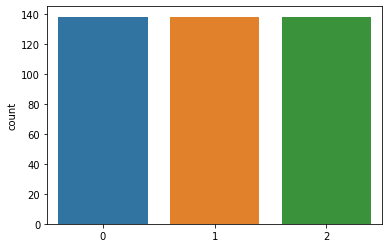

In [41]:
_ = sns.countplot(Y_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


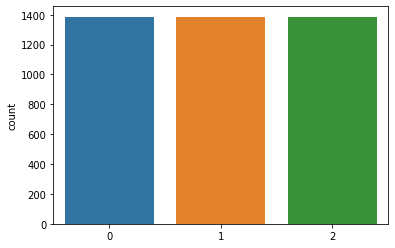

In [42]:
_ = sns.countplot(Y_train_val)

In [43]:
def load_image(full_path):
    # print(f'Loading, {full_path}')
    img = cv2.imread(full_path, cv2.IMREAD_COLOR)
    # print(type(img))
    return img

/content/drive/MyDrive/UNIPD/HDA/Project/TrainData/covid/COVID-19 (425).jpg


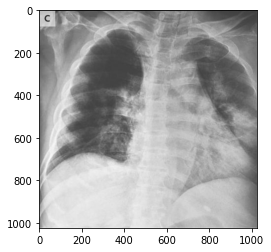

In [44]:
print(X_train_val[0])
im = load_image(X_train_val[0])
plt.imshow(im.astype('uint8'))

# Creating dataset

In [45]:
def get_dataset(
    path,
    batch_size,
    image_size,
    shuffle,
    seed,
    subset,
    validation_split = None
):  

    ds = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels = 'inferred',
        label_mode = 'int',
        color_mode = 'rgb',
        batch_size = batch_size,
        image_size = image_size,
        shuffle = shuffle,
        seed = seed,
        validation_split = validation_split,
        subset = subset
    )

    #ds = ds.repeat()
    return {
        'class names': ds.class_names,
        'data': ds.cache().prefetch(
            buffer_size = tf.data.experimental.AUTOTUNE
        )
    }
    
ds_train = get_dataset(
    path = DataProperties.train_data_path,
    batch_size = DatasetParameters.batch_size,
    image_size = PreprocParameters.resize_shape,
    shuffle = DatasetParameters.shuffle_train,
    seed = DatasetParameters.seed,
    subset = 'training',
    validation_split = DatasetParameters.validation_split
)

ds_validation = get_dataset(
    path = DataProperties.train_data_path,
    batch_size = DatasetParameters.batch_size,
    image_size = PreprocParameters.resize_shape,
    shuffle = DatasetParameters.shuffle_validation,
    seed = DatasetParameters.seed,
    subset = 'validation',
    validation_split = DatasetParameters.validation_split
)

ds_test = get_dataset(
    path = DataProperties.test_data_path,
    batch_size = DatasetParameters.batch_size,
    image_size = PreprocParameters.resize_shape,
    shuffle = DatasetParameters.shuffle_test,
    seed = DatasetParameters.seed,
    subset = None,
    validation_split = None
)

Found 4161 files belonging to 3 classes.
Using 2913 files for training.
Found 4161 files belonging to 3 classes.
Using 1248 files for validation.
Found 414 files belonging to 3 classes.


In [46]:
# ds_train = ds_train.repeat()
# ds_validation = ds_validation.repeat()

# ds_train = ds_train.prefetch(buffer_size = 1)
# ds_validation = ds_validation.prefetch(buffer_size = 1)

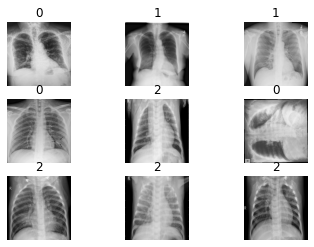

In [47]:
for images, labels in ds_train['data'].take(1):
    for i in range(9): #(batch_size):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(str(labels[i].numpy()))
        plt.axis("off")

In [48]:
# testing
from nose.tools import assert_equal

assert_equal(ds_train['class names'], ds_test['class names'])
assert_equal(ds_train['class names'], ds_validation['class names'])

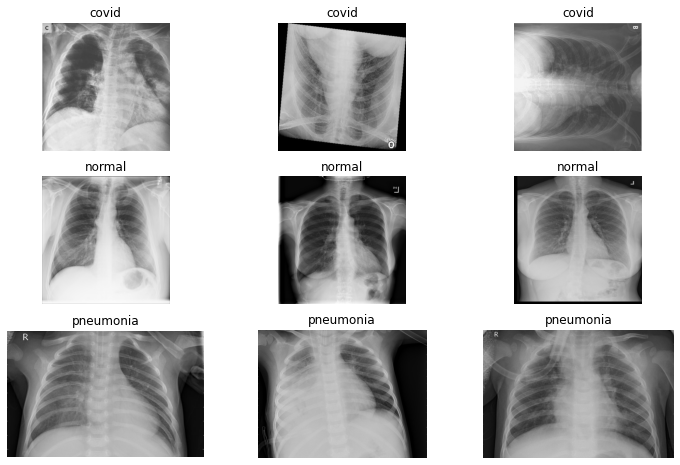

In [49]:
train_class_names = ds_train['class names']
n_classes = len(train_class_names)
n_plot = 3


fig, axes = plt.subplots(n_classes, n_plot, figsize = (12, 8))

for i, class_name in enumerate(train_class_names):
    # print(f'class name: {class_name}')
    full_dir = DataProperties.train_data_path + class_name
    # print(f'Full dir: {full_dir}')
    images_full_dirs = listdir(full_dir)[: n_plot]
    # print(images_full_dirs)
    images = [load_image(full_dir + '/' + dir) for dir in images_full_dirs]

    for j, image in enumerate(images):
        axes[i, j].imshow(image)
        axes[i, j].axis('off')
        axes[i, j].set_title(class_name)

# Data preprocessing

## Normalization

In [50]:
def normalize_image(image, y):
    return tf.cast(image, tf.float32) / 255., y

In [51]:
ds_train = ds_train['data']
ds_test = ds_test['data']
ds_validation = ds_validation['data']

In [52]:
ds_train = ds_train.map(normalize_image)
ds_validation = ds_validation.map(normalize_image)
ds_test = ds_test.map(normalize_image)

In [54]:
def test_max_pix_val(ds, max_val):
    for images, labels in ds.take(1):
        for i in range(DatasetParameters.batch_size):
            maximum = np.max(images[i].numpy())
            if maximum > max_val:
                print(f'Max value of image: {maximum}')
                raise ValueError

test_max_pix_val(ds_train, max_val = 1.0)
test_max_pix_val(ds_validation, max_val = 1.0)
test_max_pix_val(ds_test, max_val = 1.0)

# CNN architecture

In [55]:
def conv_2d_pooling_layers(n_filters):
    return [
            Conv2D(
                filters = n_filters,
                kernel_size = (3, 3),
                padding = 'same',
                activation = 'elu'
            ),
            MaxPool2D()
    ]

In [56]:
input_layer = [
               Input(shape = PreprocParameters.resize_shape + PreprocParameters.n_color_channels)
]

In [57]:
core_layers = conv_2d_pooling_layers(16) + \
            conv_2d_pooling_layers(32) + \
            conv_2d_pooling_layers(64) + \
            conv_2d_pooling_layers(256)

In [58]:
dense_layers = [
                Flatten(),
                Dense(128, activation = 'elu'),
                Dense(DataProperties.n_classes, activation = 'softmax')
]

In [59]:
cnn_model = tf.keras.Sequential(
        input_layer + \
        core_layers + \
        dense_layers
)

In [60]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False)  # normalized softmax
cnn_model.compile(
    optimizer = 'adam',
    loss = loss,
    metrics = ['accuracy']
)

In [61]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 2,  # 3
    mode = 'auto',
    restore_best_weights = True
)

In [62]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 37, 37, 64)       0

In [63]:
history = cnn_model.fit(
    ds_train,
    validation_data = ds_validation,
    epochs = 20,
    callbacks = [callback]
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


92/92 [==============================] - 326s 3s/step - loss: 1.7505 - accuracy: 0.5304 - val_loss: 0.6508 - val_accuracy: 0.6763
Epoch 2/20
92/92 [==============================] - 14s 155ms/step - loss: 0.4953 - accuracy: 0.7889 - val_loss: 0.4032 - val_accuracy: 0.8373
Epoch 3/20
92/92 [==============================] - 14s 155ms/step - loss: 0.3323 - accuracy: 0.8740 - val_loss: 0.2507 - val_accuracy: 0.9191
Epoch 4/20
92/92 [==============================] - 14s 154ms/step - loss: 0.2492 - accuracy: 0.9186 - val_loss: 0.2111 - val_accuracy: 0.9311
Epoch 5/20
92/92 [==============================] - 14s 155ms/step - loss: 0.2216 - accuracy: 0.9313 - val_loss: 0.2059 - val_accuracy: 0.9375
Epoch 6/20
92/92 [==============================] - 14s 155ms/step - loss: 0.2048 - accuracy: 0.9313 - val_loss: 0.1950 - val_accuracy: 0.9407
Epoch 7/20
92/92 [==============================] - 15s 162ms/step - loss: 0.1753 - accuracy: 0.9440 - val_loss: 0.1861 - val_accuracy: 0.9423
Epoch 8/20
9

In [64]:
cnn_model.evaluate(
    ds_test
)

13/13 [==============================] - 20s 1s/step - loss: 1.4277 - accuracy: 0.6449


[1.427657961845398, 0.6449275612831116]

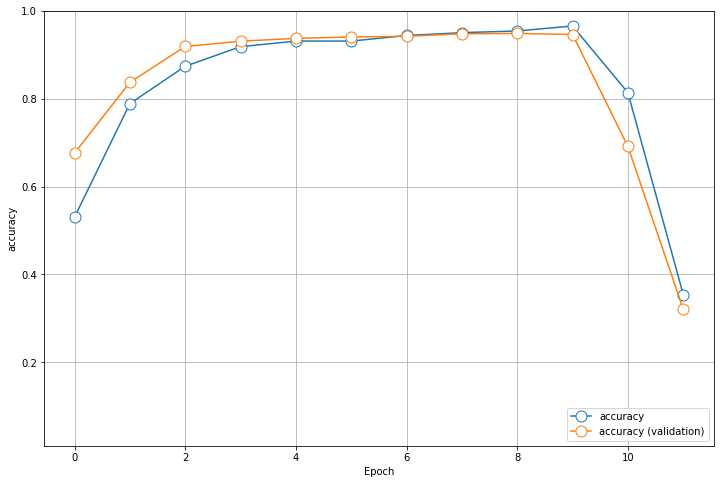

In [65]:
def plot_history(history, metrics_name, figsize = (12, 8)):
    fig, ax = plt.subplots(figsize = figsize)
    ax.plot(
        history[metrics_name], 
        label = metrics_name,
        marker = 'o',
        markersize = 11,
        markerfacecolor = 'white'
    )
    
    plt.plot(
        history['val_' + metrics_name], 
        label = metrics_name + ' (validation)',
        marker = 'o',
        markersize = 11,
        markerfacecolor = 'white'
    )
    
    plt.xlabel('Epoch')
    plt.ylabel(metrics_name)
    plt.ylim([0.01, 1])
    plt.legend(loc = 'lower right')
    plt.grid()

plot_history(
    history = history.history,
    metrics_name = 'accuracy'
)

# CNN

In [66]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(3))

In [67]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 149, 149, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 322624)           

In [68]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [69]:
len(X_train), len(X_test)

NameError: ignored

In [ ]:
train_steps = int(np.ceil(len(X_train) / batch_size))
test_steps = int(np.ceil(len(X_test) / batch_size))

In [71]:
history = model.fit(
    ds_train,  # ds_validation,
    epochs = 10,
    #steps_per_epoch = train_steps,
    #validation_steps = test_steps,
    validation_data = ds_validation,
    verbose = 2
)

Epoch 1/10
92/92 - 19s - loss: 6.0633 - accuracy: 0.4432 - val_loss: 6.0658 - val_accuracy: 0.4639 - 19s/epoch - 207ms/step
Epoch 2/10
92/92 - 16s - loss: 6.0658 - accuracy: 0.4511 - val_loss: 6.0658 - val_accuracy: 0.4639 - 16s/epoch - 177ms/step
Epoch 3/10
92/92 - 16s - loss: 6.0658 - accuracy: 0.4511 - val_loss: 6.0658 - val_accuracy: 0.4639 - 16s/epoch - 179ms/step
Epoch 4/10
92/92 - 16s - loss: 6.0658 - accuracy: 0.4511 - val_loss: 6.0658 - val_accuracy: 0.4639 - 16s/epoch - 178ms/step
Epoch 5/10
92/92 - 16s - loss: 6.0658 - accuracy: 0.4511 - val_loss: 6.0658 - val_accuracy: 0.4639 - 16s/epoch - 179ms/step
Epoch 6/10
92/92 - 17s - loss: 6.0658 - accuracy: 0.4511 - val_loss: 6.0658 - val_accuracy: 0.4639 - 17s/epoch - 179ms/step
Epoch 7/10
92/92 - 16s - loss: 6.0658 - accuracy: 0.4511 - val_loss: 6.0658 - val_accuracy: 0.4639 - 16s/epoch - 177ms/step
Epoch 8/10
92/92 - 16s - loss: 6.0658 - accuracy: 0.4511 - val_loss: 6.0658 - val_accuracy: 0.4639 - 16s/epoch - 178ms/step
Epoch 9/

In [72]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

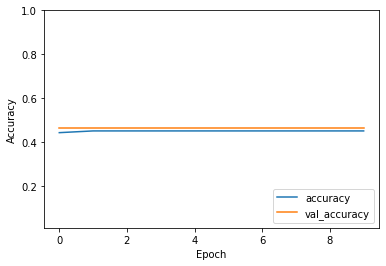

In [73]:
plt.plot(history.history['accuracy'], label='accuracy')

plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.01, 1])
plt.legend(loc='lower right')

In [ ]:
test_loss, test_acc = model.evaluate(ds_validation, verbose = 2)  # (ds_train, verbose=2)
print(test_acc)

ValueError: ignored

## Other stuff

In [ ]:
def LOAD_IMAGE(full_path):
    print(f'Loading, {full_path}')
    file = tf.io.read_file(full_path)
    extension = full_path[-3:]
    if extension == 'jpg':
        image_decoded = tf.io.decode_jpeg(file, channels=3)
        image = tf.cast(image_decoded, tf.float32)
        
    if extension == 'png':
        image_decoded = tf.io.decode_jpeg(file, channels=3)
        image = tf.cast(image_decoded, tf.float32)
    else:
        image_decoded = tf.io.decode_jpeg(file, channels=3)
        image = tf.cast(image_decoded, tf.float32)
    return image

def resize_image(image, new_shape):
    n = cv2.resize(image, new_shape)
    return n

def normalize_image(image):
    return tf.cast(image, tf.float32) / 255.


def create_dataset(file_names, shuffle, cache_file):
    dataset = tf.data.Dataset.from_tensor_slices(
        file_names
    )

    # load image func
    load_im = lambda full_path: (
        tf.numpy_function(LOAD_IMAGE, [full_path], tf.float32)
    )

    # # resize
    # resize_im = lambda image: (
    #     tf.numpy_function(
    #         resize_image, 
    #         [image, PreprocParameters.resize_shape], 
    #         tf.float32
    #     )
    # )

    # # normalize
    # normalize_im = lambda image: (
    #     tf.numpy_function(
    #         normalize_image,
    #         [image],
    #         tf.float32
    #     )
    # )

    dataset = dataset.map(load_im, num_parallel_calls = os.cpu_count())
    # dataset = dataset.map(resize_im, num_parallel_calls = os.cpu_count())
    # dataset = dataset.map(normalize_im, num_parallel_calls = os.cpu_count())

    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)

    # Shuffle
    #if shuffle:
    #    dataset = dataset.shuffle(len(file_names))

    # Repeat the dataset indefinitely
    # dataset = dataset.repeat()

    # Batch
    # dataset = dataset.batch(
     #   batch_size = TrainParameters.batch_size
    #)

    # Prefetch
    #dataset = dataset.prefetch(buffer_size = 1)

    return dataset

In [ ]:
train_dataset = create_dataset(
    X_train,
    shuffle = True,
    cache_file = None # 'train_cache'
)

test_dataset = create_dataset(
    X_test,
    shuffle = True,
    cache_file = None # 'test_cache'
)

# CNN model

In [ ]:
train_dataset.take(2)

<TakeDataset shapes: <unknown>, types: tf.float32>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loading, b'/content/drive/MyDrive/UNIPD/HDA/Project/Data/covid/COVID-19 (527).jpg'
Loading, b'/content/drive/MyDrive/UNIPD/HDA/Project/Data/normal/00000419_000.png'
Loading, b'/content/drive/MyDrive/UNIPD/HDA/Project/Data/covid/COVID-19 (408).jpg'
Loading, b'/content/drive/MyDrive/UNIPD/HDA/Project/Data/normal/00000366_001.png'
Loading, b'/content/drive/MyDrive/UNIPD/HDA/Project/Data/normal/00000370_007.png'
Loading, b'/content/drive/MyDrive/UNIPD/HDA/Project/Data/pneumonia/person1313_bacteria_3320.jpeg'
Loading, b'/content/drive/MyDrive/UNIPD/HDA/Project/Data/normal/00000427_001.png'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


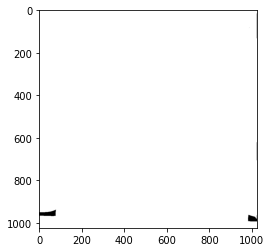

In [ ]:
for im in train_dataset.take(5):
    plt.imshow(im)